## Load Library

In [443]:
import pycurl
from io import BytesIO
import bs4
from bs4 import BeautifulSoup
from bs4 import NavigableString
from tqdm import tqdm_notebook
from pandas import DataFrame
import pandas as pd
import os, sys
from time import sleep

## Load Functions

In [444]:
def search(url):
    buffer = BytesIO()
    storage = BytesIO()
    c = pycurl.Curl()
    c.setopt(c.URL, url)
    c.setopt(c.WRITEDATA, buffer)
    c.perform()
    c.close()
    body = buffer.getvalue()
    soup = BeautifulSoup(body, 'html.parser')
    return soup

def get_author_id(term, uni):
    term_up = term.upper()
    term_ref = term_up.replace(' ', '+')
    
    url = 'http://sinta2.ristekdikti.go.id/affiliations/detail?q='+ term_ref +'&search=1&view=authors&id='+uni
    author_search = search(url)
    
    for a in author_search.find_all('a', href=True):
        if term_up in a:
            url_id = (a['href'])
            auth_id = url_id.replace('/authors/detail/?id=', "")
            auth_idx = auth_id.replace('&view=overview', "")
    return auth_idx

def get_author_rank(auth_id1):
    url2 = 'http://sinta2.ristekdikti.go.id/authors/detail?id='+auth_id1+'&view=overview'
    info = search(url2)

    for a in info.find_all('div', class_='stat-lbl-big'):
        for i in a.contents:
            if "Rank in National" in i:
                x = a.find_previous('div', class_="stat-num")
                print('Rank in National '+x.contents[0])
            if "Rank in Affiliation" in i:
                x = a.find_previous('div', class_="stat-num")
                print('Rank in Affiliation '+x.contents[0])
            if " Score" in i:
                x = a.find_previous('div', class_="stat-num")
                print('SINTA Score '+x.contents[0])
            
    for a in info.find_all('div', class_='uk-width-2-10 uk-row-first stat-lbl-pub'):
        for i in a.contents:
            if "scopus" in i['src']:
                x = a.find_next('div', class_="uk-width-2-10 stat-num-pub")
                print('Scopus '+x.contents[0])
            if "scholar" in i['src']:
                x = a.find_next('div', class_="uk-width-2-10 stat-num-pub")
                print('Google Scholar '+x.contents[0])
    return

def get_author_info(term, uni):
    auth_id2 = get_author_id(term, uni)
    
    url2 = 'http://sinta2.ristekdikti.go.id/authors/detail?id='+auth_id2+'&view=overview'
    info = search(url2)
    
    for a in info.find_all('div', class_='stat-lbl-big'):
        for i in a.contents:
            if "Rank in National" in i:
                nr = a.find_previous('div', class_="stat-num")
                n_r = nr.contents[0]
            if "Rank in Affiliation" in i:
                ar = a.find_previous('div', class_="stat-num")
                a_r = ar.contents[0]
            if " Score" in i:
                ss = a.find_previous('div', class_="stat-num")
                s_s = ss.contents[0]
            
    for a in info.find_all('div', class_='uk-width-2-10 uk-row-first stat-lbl-pub'):
        for i in a.contents:
            if "scopus" in i['src']:
                s_a = a.find_next('div', class_="uk-width-2-10 stat-num-pub")
                s_c = s_a.find_next('div', class_="uk-width-2-10 stat-num-pub")
                s_i = s_c.find_next('div', class_="uk-width-2-10 stat-num-pub")
                sa = s_a.contents[0]
                sc = s_c.contents[0]
                si = s_i.contents[0]
            if "scholar" in i['src']:
                g_a = a.find_next('div', class_="uk-width-2-10 stat-num-pub")
                g_c = g_a.find_next('div', class_="uk-width-2-10 stat-num-pub")
                g_i = g_c.find_next('div', class_="uk-width-2-10 stat-num-pub")
                ga = g_a.contents[0]
                gc = g_c.contents[0]
                gi = g_i.contents[0]
    df_data = [term, auth_id2, n_r, a_r, s_s, si, gi, sa, sc, ga, gc]
    return df_data

def nidn(term, uni):
    term_up = term.upper()
    term_ref = term_up.replace(' ', '+')
    url = 'http://sinta2.ristekdikti.go.id/affiliations/detail?q='+ term_ref +'&search=1&view=authors&id='+uni
    author_search = search(url)
    for a in author_search.find_all('small'):
        if '/NIP/NIDK' in a.contents[0]:
            NIDN = a.next_sibling
            NIDN = NIDN.replace(' : ','')
    return NIDN

## Test

In [448]:
#Get SINTA ID
uni = '384'
term = 'Matin Nuhamunada'
author_id2 = get_author_id(term, uni)
author_id2

'6014421'

In [449]:
#Get HTML page of author's information based on SINTA ID
url2 = 'http://sinta2.ristekdikti.go.id/authors/detail?id='+author_id2+'&view=overview'
info = search(url2)
#info

In [450]:
#Create Empty Dataframe to contain data
df_data = DataFrame(columns=('Nama', \
                             "SINTA ID", \
                             "Rank National", \
                             "Rank Affiliation", \
                             "Sinta Score", \
                             "Scopus H-Index", \
                             "Google H-Index", \
                             "Scopus Art.", \
                             "Scopus Cit.", \
                             "Scholar Art.", \
                             "Scholar Cit." \
                            )
                    )
df_data.index.name = 'No'

In [452]:
#Test for multiple author search
biologi = {'Nama' : ["Matin Nuhamunada", "Indra Lesmana"]}
df_biologi = DataFrame(data=biologi)
df_biologi.index.name = 'No'
for i in tqdm_notebook(range(len(df_biologi))):
    df_data.loc[i] = get_author_info(df_biologi.loc[i, "Nama"], uni)
df_data

,Nama,SINTA ID,Rank National,Rank Affiliation,Sinta Score,Scopus H-Index,Google H-Index,Scopus Art.,Scopus Cit.,Scholar Art.,Scholar Cit.
No,,,,,,,,,,,
0,Matin Nuhamunada,6014421,11056,848,1.37,1,1,3,4,5,4
1,Indra Lesmana,6023357,22845,1207,0.29,0,0,2,0,3,0


## Data Mining of Lecturers from the Faculty of Biology UGM

In [453]:
lecturer = search('http://biologi.ugm.ac.id/en/lectures/')
#lecturer

In [454]:
lec_list = []
for i in lecturer.find_all('div', class_='elementor-tab-content elementor-clearfix'):
    for a in i.contents:
        for x in a.contents:
            if isinstance(x, NavigableString):
                pass
            else:
                #print(x.find_all('strong'))
                for b in x.find_all('strong'):#, href=True):
                    for c in b.contents:
                        if not isinstance(c, bs4.element.NavigableString):
                            if isinstance(c.contents[0], bs4.element.NavigableString):
                                d = c.contents[0]
                                lec_list.append(str(d))

In [455]:
lec_list = []
for i in lecturer.find_all('div', class_='elementor-tab-content elementor-clearfix'):
    for a in i.contents:
        for x in a.contents:
            if isinstance(x, NavigableString):
                pass
            else:
                #print(x.find_all('strong'))
                for b in x.find_all('strong'):#, href=True):
                    for c in b.contents:
                        if isinstance(c, bs4.element.NavigableString):
                            #print(c)
                            d = c
                            lec_list.append(str(d))
                        else:
                            if not isinstance(c, bs4.element.NavigableString):
                                if isinstance(c.contents[0], bs4.element.NavigableString):
                                    #print(c.contents[0])
                                    d = c.contents[0]
                                    lec_list.append(str(d))
#lec_list                                       

In [456]:
import re
replaced = [w.replace('Prof. Dr.\xa0', '')\
            .replace('Prof. Dr. ', '')\
            .replace('Prof. Dra. ', '')\
            .replace('Dr.rer.nat. ', '')\
            .replace('Dr. rer.nat. ', '')\
            .replace('Dr.biol.hom. ', '')\
            .replace('Dr.med.vet. ', '')\
            .replace('Dra. ', '')\
            .replace('Drs. ', '')\
            .replace('Dr. ', '')\
            .replace('Dr.\xa0', '')\
            .replace('S.S., ', '')\
            .replace(', ', '')\
            .replace('M.Sc.', '')\
            .replace('Ph.D.', '')\
            .replace('M.Si.', '')\
            .replace('M.Si', '')\
            .replace('M.S.', '')\
            .replace('M.App.Sc.', '')\
            .replace('S.Si. ', '')\
            .replace('S.Si.', '')\
            .replace('S.U.', '')\
            .replace('M.Biotech.', '')\
            .replace(' M.Env.Sc', '')\
            .replace('M.Agr.Sc.', '')\
            .replace('M. Eng.', '')\
            .replace('M.Agr.', '')\
            .replace('M.Kes.', '')\
            .replace('M.P.', '')\
            .replace('DAP', '')\
            .replace('MS.', '')\
            .replace('St.', '')\
            .replace('\xa0', '')\
            for w in lec_list]
#replaced

In [457]:
replaced2 = [w.replace('Niken Satuti Handayani', 'Niken Satuti Nur Handayani') \
             .replace('Ganies Riza A.', 'Ganies Riza Aristya') \
             .replace('L. Hartanto Nugroho', 'Laurentius Hartanto Nugroho') \
             .replace('Diah Rahmawati', 'Diah Rachmawati') \
             .replace('Rr. Upiek Ngesti W.A.', 'Rr Upiek Ngesti Wibawaning A') \
             .replace('Soenarwan Heri Poerwanto', 'Soenarwan Hery Poerwanto') \
             .replace('Dila Hening Windyarini', 'Dila Hening Windyaraini') \
             .replace('Susilo Hadi', 'Susilohadi') \
             .replace('Hendry T.S.S.G. Saragih', 'Hendry TSSG Saragih') \
             .replace('R.C. Hidayat Soesilohadi', 'R C Hidayat Soesilohadi') \
             .replace('Mulyati Sarto', 'Mulyati') \
             .replace('Slamet Widianto', 'Slamet Widiyanto') \
             .replace('Agnes Endang Sutariningsih', 'Agnes Endang Sutariningsih S') \
             .replace('.', '')\
             .replace(',', '')\
             for w in replaced]

In [458]:
biologi2 = {'Nama' : replaced2}
df_biologi2 = DataFrame(data=biologi2)
df_biologi2.index.name = 'No'
df_biologi3 = df_biologi2.drop([27])
df_biologi3.index = pd.RangeIndex(len(df_biologi3.index))
#df_biologi3

## Get SINTA Data from UGM Biology Lecturers

In [459]:

if not os.path.isfile('data3.csv'):
    df_data2 = DataFrame(columns=('Nama', \
                                  "SINTA ID", \
                                  "Rank National", \
                                  "Rank Affiliation", \
                                  "Sinta Score", \
                                  "Scopus H-Index", \
                                  "Google H-Index", \
                                  "Scopus Art.", \
                                  "Scopus Cit.", \
                                  "Scholar Art.", \
                                  "Scholar Cit." \
                                 )
                     
                        )
    df_data2.index.name = 'No'
else:
    df_data2 = pd.read_csv('data3.csv', index_col=0)
pbar = tqdm_notebook(range(len(df_biologi3))) #to make progressbar    
for i in pbar:
    if not i in df_data2.index:
        try:
            df_data2.loc[i] = get_author_info(df_biologi3.loc[i, "Nama"])
            pbar.set_description('processed: %d' % (i))
            pbar.update(1)
            sleep(1)
        except:
            print('error '+df_biologi3.loc[i, "Nama"])
            pass

In [460]:
#df_data2

In [461]:
df_data2.to_csv('data3.csv')

In [462]:
df_data3 = pd.read_csv('data3.csv', index_col=0)
rank_bio = df_data3.sort_values(by=['Rank National'], ascending=True)
rank_bio.index = pd.RangeIndex(len(rank_bio.index))+1
pd.options.display.max_rows = 70
rank_bio

,Nama,SINTA ID,Rank National,Rank Affiliation,Sinta Score,Scopus H-Index,Google H-Index,Scopus Art.,Scopus Cit.,Scholar Art.,Scholar Cit.
1,Endang Semiarti,5973460,121,10,47.51,6,9,24,759,164,1109
2,Nastiti Wijayanti,5972899,400,50,26.54,8,8,20,361,79,488
3,Yekti Asih Purwestri,21472,970,116,15.39,2,2,6,277,34,297
4,Budi Setiadi Daryono,21420,1153,136,13.59,3,7,32,31,296,257
5,Laurentius Hartanto Nugroho,5977709,1332,159,12.26,5,8,16,114,72,230
6,Rarastoeti Pratiwi,257321,2679,299,7.66,2,4,8,85,91,146
7,Maryani,6016534,2720,304,7.57,4,4,4,111,13,168
8,Eko Agus Suyono,42920,3381,367,6.20,3,4,17,21,50,43
9,Diah Rachmawati,6014449,3531,383,5.93,3,4,7,58,58,118
10,Rina Sri Kasiamdari,6003781,4349,450,4.76,2,4,7,33,78,99


## Data Mining NIDN to determine age

In [463]:
if not os.path.isfile('data_NIDN.csv'):
    df_data2 = DataFrame(columns=('Nama', \
                                  "NIDN", \
                                 )
                     
                        )
    df_data2.index.name = 'No'
else:
    df_data2 = pd.read_csv('data_NIDN.csv', index_col=0)
pbar = tqdm_notebook(range(len(df_biologi3))) #to make progressbar    
for i in pbar:
    if not i in df_data2.index:
        try:
            df_data2.loc[i] = [df_biologi3.loc[i, "Nama"], nidn(df_biologi3.loc[i, "Nama"])]
            pbar.set_description('processed: %d' % (i))
            pbar.update(1)
            sleep(1)
        except:
            print('error '+df_biologi3.loc[i, "Nama"])
            pass
        

In [131]:
#df_data2

In [464]:
df_data2.to_csv('data_NIDN.csv')

In [465]:
df_nidn = pd.read_csv('data_NIDN.csv', index_col=0)

In [466]:
df_nidn['NIDN'] = df_nidn['NIDN'].str.replace('o', '0')
df_nidn['NIDN'] = df_nidn['NIDN'].str.replace(' ', '')

In [467]:
df_age = DataFrame(columns=('DOB', \
                              "Age", \
                             )                   
                    )
df_age.index.name = 'No'

for i in range(len(df_nidn)):
    now = datetime.datetime.now()
    if not df_nidn.loc[i, 'NIDN'][:2] == '11':
        dob = '19' + df_nidn.loc[i, 'NIDN'][6:8]
        age = now.year - int(dob)
    else:
        dob = '1990'
        age = now.year - int(dob)
    df_age.loc[i] = [dob, age]

In [468]:
#df_age

In [471]:
result = pd.concat([df_data3, df_nidn['NIDN'], df_age], axis=1)
result.to_csv('result UGM.csv')
result

,Nama,SINTA ID,Rank National,Rank Affiliation,Sinta Score,Scopus H-Index,Google H-Index,Scopus Art.,Scopus Cit.,Scholar Art.,Scholar Cit.,NIDN,DOB,Age
No,,,,,,,,,,,,,,
0,Rarastoeti Pratiwi,257321,2679,299,7.66,2,4,8,85,91,146,0025106305,1963,55
1,Yekti Asih Purwestri,21472,970,116,15.39,2,2,6,277,34,297,0023057104,1971,47
2,Tri Rini Nuringtyas,21396,5198,510,3.92,3,5,7,29,36,79,0027037304,1973,45
3,Woro Anindito Sri Tunjung,6021239,4378,455,4.73,5,5,8,51,38,68,0520077903,1979,39
4,Lisna Hidayati,6002859,28119,1341,0.15,0,0,1,0,6,0,0021038604,1986,32
5,Endang Semiarti,5973460,121,10,47.51,6,9,24,759,164,1109,0023116204,1962,56
6,Ari Indrianto,6142358,62088,1853,0.00,0,0,0,0,0,0,0025115805,1958,60
7,Eko Agus Suyono,42920,3381,367,6.20,3,4,17,21,50,43,0018127101,1971,47
8,Aries Bagus Sasongko,6017558,38524,1527,0.04,0,2,0,0,8,4,0511038303,1983,35


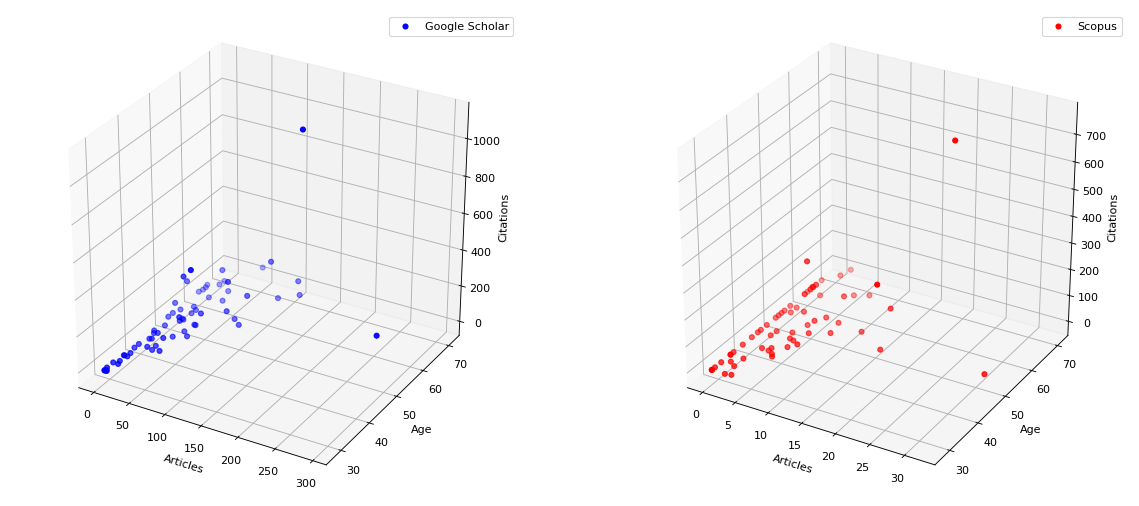

In [473]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
#fig = plt.figure(figsize=plt.figaspect(0.5))
result = pd.read_csv('result UGM.csv', index_col=0)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ys = result['Age'].values
xs = result['Scholar Art.'].values
zs = result['Scholar Cit.'].values
ax.scatter(xs, ys, zs, zdir='z', c='b', label='Google Scholar')
ax.legend()
ax.set_ylabel('Age')
ax.set_xlabel('Articles')
ax.set_zlabel('Citations')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ys = result['Age'].values
xs = result['Scopus Art.'].values
zs = result['Scopus Cit.'].values
ax.scatter(xs, ys, zs, zdir='z', c='r', label='Scopus')
ax.legend()
ax.set_ylabel('Age')
ax.set_xlabel('Articles')
ax.set_zlabel('Citations')


#plt.gca().invert_yaxis()
plt.show()

In [474]:
#Get HTML page of author's information based on SINTA ID
url2 = 'https://biologi.ub.ac.id/s1.php'
info = search(url2)
#info

In [475]:
ls = []
for i in info.find_all('a', href=True):
    if 'https://www.scopus.com' in i['href']:
        for x in i.contents:
            y = x.strip()
            #print(y)
            ls.append(y)

In [476]:
ls

['Prof. Sutiman Bambang Sumitro, SU.,D.Sc',
 'Prof.Dr.Ir. Estri Laras Arumingtyas, M.Sc.St',
 'Prof. Dra. Fatchiyah, M.Kes., Ph.D',
 'Prof. Muhaimin Rifa`i, S.Si., Ph.D.Med.Sc',
 'Dr. Sri Rahayu, M.Kes',
 'Dr. Serafinah Indriyani, M.Si',
 'Dr. Wahyu Widoretno, M.Si',
 'Dra. Nunung Harijati, MS.,Ph.D',
 'Luchman Hakim, S.Si.,M.Agr.Sc.,Ph.D',
 'Dr. Suharjono, MS',
 'Dr. Endang Arisoesilaningsih, MS',
 'Amin Setyo Leksono, S.Si.,M.Si.,Ph.D',
 'Dr.Ir. Moch. Sasmito Djati, MS',
 'Dr. Dra. Catur Retnaningdyah, M.Si',
 'Prof. Widodo, S.Si.,M.Si.,Ph.D.Med.Sc',
 'Ir. Retno Mastuti, M.Agr.Sc.,DAgr.Sc',
 'Dr. Sri Widyarti, M.Si',
 'Tri Ardyati, M.Agr., Ph.D',
 'Zulfaidah Penata Gama, S.Si., M.Si., Ph.D',
 'Nia Kurniawan, S.Si.,MP.,D.Sc',
 'Rodiyati Azrianingsih, S.Si.,M.Sc.,Ph.D',
 'Dr. Bagyo Yanuwiadi',
 'Drs. Aris Soewondo, M.Si',
 'Dian Siswanto, S.Si., M.Sc.,M.Si.,Ph.D',
 'Yoga Dwi Jatmiko, S.Si., M.App.Sc., Ph.D.']

In [477]:
import re
replaced = [w.replace('Prof. Dr.\xa0', '')\
            .replace('Prof.Dr.Ir. ', '')\
            .replace('Prof. Dr. ', '')\
            .replace('Prof. Dra. ', '')\
            .replace('Prof. ', '')\
            .replace('Dr.rer.nat. ', '')\
            .replace('Dr. rer.nat. ', '')\
            .replace('Dr.biol.hom. ', '')\
            .replace('Dr.med.vet. ', '')\
            .replace('Dra. ', '')\
            .replace('Drs. ', '')\
            .replace('Dr.Ir. ', '')\
            .replace('Ir. ', '')\
            .replace('Dr. ', '')\
            .replace('Dr.\xa0', '')\
            .replace('S.S., ', '')\
            .replace(', ', '')\
            .replace('M.Sc.St', '')\
            .replace('M.Sc.', '')\
            .replace('Ph.D.', '')\
            .replace('Ph.D', '')\
            .replace('M.Si., ', '')\
            .replace('M.Si.', '')\
            .replace('M.Si', '')\
            .replace('M.S.', '')\
            .replace('M.App.Sc.', '')\
            .replace('MP.,D.Sc', '')\
            .replace('S.Si. ', '')\
            .replace('S.Si.', '')\
            .replace('S.U.', '')\
            .replace('M.Biotech.', '')\
            .replace(' M.Env.Sc', '')\
            .replace('M.Agr.Sc.', '')\
            .replace('M. Eng.', '')\
            .replace('M.Agr.', '')\
            .replace('M.Kes.', '')\
            .replace('Med.Sc', '')\
            .replace('M.Kes', '')\
            .replace('M.P.', '')\
            .replace('DAP', '')\
            .replace('MS.', '')\
            .replace('MS', '')\
            .replace('St.', '')\
            .replace('\xa0', '')\
            .replace('SU.,D.Sc', '')\
            .replace('DAgr.Sc', '')\
            .replace(',', '')\
            .replace('Moch.', 'Mochammad')\
            .replace('Rifa`i', "Rifa'i")\
            for w in ls]
replaced

['Sutiman Bambang Sumitro',
 'Estri Laras Arumingtyas',
 'Fatchiyah',
 "Muhaimin Rifa'i",
 'Sri Rahayu',
 'Serafinah Indriyani',
 'Wahyu Widoretno',
 'Nunung Harijati',
 'Luchman Hakim',
 'Suharjono',
 'Endang Arisoesilaningsih',
 'Amin Setyo Leksono',
 'Mochammad Sasmito Djati',
 'Catur Retnaningdyah',
 'Widodo',
 'Retno Mastuti',
 'Sri Widyarti',
 'Tri Ardyati',
 'Zulfaidah Penata Gama',
 'Nia Kurniawan',
 'Rodiyati Azrianingsih',
 'Bagyo Yanuwiadi',
 'Aris Soewondo',
 'Dian Siswanto',
 'Yoga Dwi Jatmiko']

In [478]:
biologi_ub = {'Nama' : replaced}
df_biologi_ub2 = DataFrame(data=biologi_ub)
df_biologi_ub2.index.name = 'No'
#df_biologi_ub3 = df_biologi_ub2.drop([27])
#df_biologi_ub3.index = pd.RangeIndex(len(df_biologi_ub3.index))
df_biologi_ub2

,Nama
No,
0,Sutiman Bambang Sumitro
1,Estri Laras Arumingtyas
2,Fatchiyah
3,Muhaimin Rifa'i
4,Sri Rahayu
5,Serafinah Indriyani
6,Wahyu Widoretno
7,Nunung Harijati
8,Luchman Hakim


In [479]:
uni = '404'
if not os.path.isfile('data_NIDN_ub.csv'):
    df_data2 = DataFrame(columns=('Nama', \
                                  "NIDN", \
                                 )
                     
                        )
    df_data2.index.name = 'No'
else:
    df_data2 = pd.read_csv('data_NIDN_ub.csv', index_col=0)
pbar = tqdm_notebook(range(len(df_biologi_ub2))) #to make progressbar    
for i in pbar:
    if not i in df_data2.index:
        try:
            df_data2.loc[i] = [df_biologi_ub2.loc[i, "Nama"], nidn(df_biologi_ub2.loc[i, "Nama"], uni)]
            pbar.set_description('processed: %d' % (i))
            pbar.update(1)
            sleep(1)
        except:
            print('error '+df_biologi_ub2.loc[i, "Nama"])
            pass

df_nidn_ub = df_data2    



error Nunung Harijati
error Suharjono
error Tri Ardyati
error Rodiyati Azrianingsih
error Bagyo Yanuwiadi
error Aris Soewondo


In [480]:
df_nidn_ub

,Nama,NIDN
No,,
0,Sutiman Bambang Sumitro,11035404
1,Estri Laras Arumingtyas,18086306
2,Fatchiyah,27116307
4,Sri Rahayu,28056206
5,Serafinah Indriyani,9096306
6,Wahyu Widoretno,14046307
8,Luchman Hakim,8087102
10,Endang Arisoesilaningsih,8095905
11,Amin Setyo Leksono,171172003


In [481]:
df_nidn_ub.to_csv('data_NIDN_ub.csv')

In [482]:

if not os.path.isfile('data4_ub.csv'):
    df_data2 = DataFrame(columns=('Nama', \
                                  "SINTA ID", \
                                  "Rank National", \
                                  "Rank Affiliation", \
                                  "Sinta Score", \
                                  "Scopus H-Index", \
                                  "Google H-Index", \
                                  "Scopus Art.", \
                                  "Scopus Cit.", \
                                  "Scholar Art.", \
                                  "Scholar Cit." \
                                 )
                     
                        )
    df_data2.index.name = 'No'
else:
    df_data2 = pd.read_csv('data4_ub.csv', index_col=0)
pbar = tqdm_notebook(df_nidn_ub.index.values) #to make progressbar    
for i in pbar:
    if not i in df_data2.index:
        #try:
            df_data2.loc[i] = get_author_info(df_nidn_ub.loc[i, "Nama"], '404')
            pbar.set_description('processed: %d' % (i))
            pbar.update(1)
            sleep(1)
        #except:
        #    print('error '+df_nidn_ub.loc[i, "Nama"])
        #    pass

In [483]:
df_sinta_ub = df_data2
df_sinta_ub.to_csv('data4_ub.csv')
rank_bio_ub = df_data2.sort_values(by=['Rank National'], ascending=True)
rank_bio_ub.index = pd.RangeIndex(len(rank_bio_ub.index))+1
pd.options.display.max_rows = 70
rank_bio_ub

,Nama,SINTA ID,Rank National,Rank Affiliation,Sinta Score,Scopus H-Index,Google H-Index,Scopus Art.,Scopus Cit.,Scholar Art.,Scholar Cit.
1,Widodo,5982480,96,2,52.48,13,14,65,529,105,787
2,Muhaimin Rifa'i,6118973,125,3,47.20,9,12,32,696,119,1184
3,Sutiman Bambang Sumitro,5998175,542,13,22.44,5,8,38,127,100,255
4,Amin Setyo Leksono,5984023,2044,48,9.67,1,8,15,5,108,268
5,Luchman Hakim,6037433,2524,62,8.05,3,9,11,14,120,350
6,Mochammad Sasmito Djati,6036875,2722,66,7.57,4,6,15,30,76,127
7,Wahyu Widoretno,6036949,7464,239,2.47,1,4,5,4,33,61
8,Estri Laras Arumingtyas,5978827,7832,249,2.31,0,7,0,0,70,236
9,Dian Siswanto,5996481,9328,289,1.79,2,4,4,12,25,25
10,Catur Retnaningdyah,5979040,10059,312,1.61,0,5,3,0,56,94


In [484]:
df_age_ub = DataFrame(columns=('DOB', \
                              "Age", \
                             )                   
                    )
df_age_ub.index.name = 'No'

for i in df_nidn_ub.index.values:
    now = datetime.datetime.now()
    dob = '19' + str(df_nidn_ub.loc[i, 'NIDN'])[-4:-2]
    age = now.year - int(dob)
    if age <= 70:
        dob = int(dob)
    else:
        dob = 1990
    age = now.year - dob
    df_age_ub.loc[i] = [dob, age]

In [485]:
str(df_nidn_ub.loc[0, 'NIDN'])[-4:-2]

'54'

In [486]:
df_nidn_ub

,Nama,NIDN
No,,
0,Sutiman Bambang Sumitro,11035404
1,Estri Laras Arumingtyas,18086306
2,Fatchiyah,27116307
4,Sri Rahayu,28056206
5,Serafinah Indriyani,9096306
6,Wahyu Widoretno,14046307
8,Luchman Hakim,8087102
10,Endang Arisoesilaningsih,8095905
11,Amin Setyo Leksono,171172003


In [487]:
#for i in df_nidn_ub.index.values:
#    print(i)
df_age_ub

,DOB,Age
No,,
0,1954,64
1,1963,55
2,1963,55
4,1962,56
5,1963,55
6,1963,55
8,1971,47
10,1959,59
11,1990,28


In [489]:
x = pd.read_csv('data4_ub.csv', index_col=0)
result_ub = pd.concat([x, df_nidn_ub['NIDN'], df_age_ub], axis=1)
result_ub.to_csv('data UB.csv')

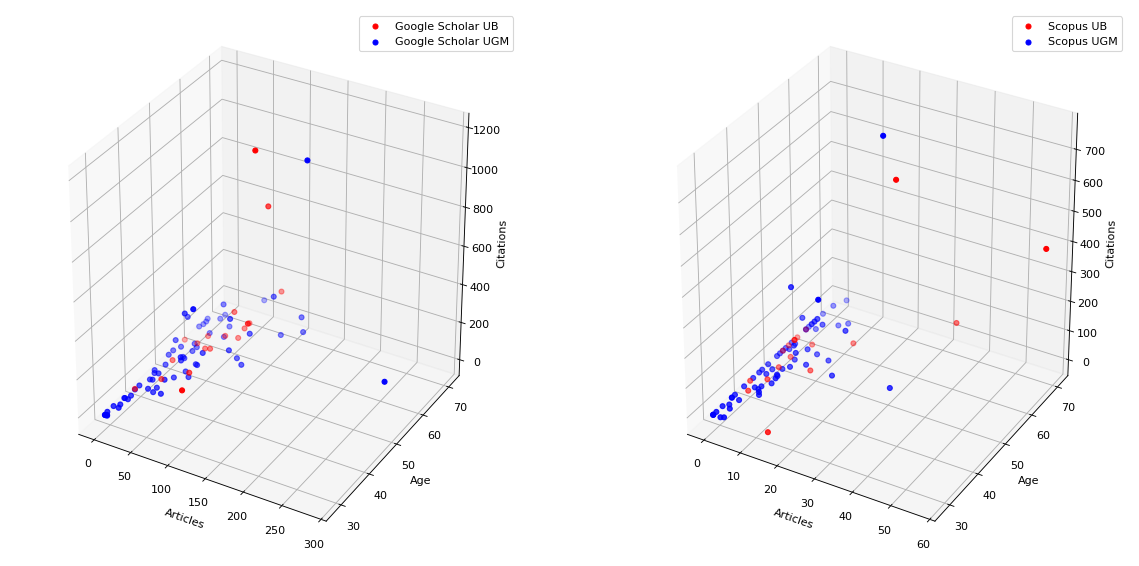

In [504]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
#fig = plt.figure(figsize=plt.figaspect(0.5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')

result_ub = pd.read_csv('data UB.csv')
ys = result_ub['Age'].values
xs = result_ub['Scholar Art.'].values
zs = result_ub['Scholar Cit.'].values
ax1.scatter(xs, ys, zs, zdir='z', c='r', label='Google Scholar UB')

result = pd.read_csv('result UGM.csv', index_col=0)
ys1 = result['Age'].values
xs1 = result['Scholar Art.'].values
zs1 = result['Scholar Cit.'].values
ax1.scatter(xs1, ys1, zs1, zdir='z', c='b', label='Google Scholar UGM')

ax1.legend()
ax1.set_ylabel('Age')
ax1.set_xlabel('Articles')
ax1.set_zlabel('Citations')
plt.xlim(xmax=300)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ys = result_ub['Age'].values
xs = result_ub['Scopus Art.'].values
zs = result_ub['Scopus Cit.'].values
ax2.scatter(xs, ys, zs, zdir='z', c='r', label='Scopus UB')

ys2 = result['Age'].values
xs2 = result['Scopus Art.'].values
zs2 = result['Scopus Cit.'].values
ax2.scatter(xs2, ys2, zs2, zdir='z', c='b', label='Scopus UGM')

ax2.legend()
plt.xlim(xmax=60)
ax2.set_ylabel('Age')
ax2.set_xlabel('Articles')
ax2.set_zlabel('Citations')

plt.show()